<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/b-vanilla-neural-network-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a vanilla Backpropagation algorithm



In this section, we will learn how to implement the backpropagation algorithm from scratch using Python. 

**What is Backpropagation?**
Back-propagation is the essence of neural net training. It is the method of fine-tuning the weights of a neural net based on the error rate obtained in the previous epoch (i.e., iteration). Proper tuning of the weights allows you to reduce error rates and to make the model reliable by increasing its generalization.

Backpropagation is a short form for "backward propagation of errors." It is a standard method of training artificial neural networks. This method helps to calculate the gradient of a loss function with respects to all the weights in the network.

The backpropagation algorithm consists of two phases:
- 1. The forward pass where we pass our inputs through the network to obtain our output classifications.

-  2. The backward pass (i.e., weight update phase) where we compute the gradient of the loss function and use this information to iteratively apply the chain rule to update the weights in our network.

<img src="https://www.guru99.com/images/1/030819_0937_BackPropaga1.png">



In [2]:

from __future__ import print_function
import numpy as np 
np.random.seed(42)

# Concepts

Before we dive into our neural network implementation, lets look at some important concepts.

## The dot product

The dot product of two vectors tells you how similar they are in terms of direction and is scaled by the magnitude of the two vectors.



In [ ]:
input_vector = [1.72, 1.23]
weights_1 = [1.26, 0]
weights_2 = [2.17, 0.32]

# Computing the dot product of input_vector and weights_1
first_indexes_mult = input_vector[0] * weights_1[0]
second_indexes_mult = input_vector[1] * weights_1[1]
dot_product_1 = first_indexes_mult + second_indexes_mult

print(f"The dot product 1 is: {dot_product_1}")

#use np instead
dot_product_2 = np.dot(input_vector, weights_2)
print(f"The dot product 2 is: {dot_product_2}")
print(f"The dot product 2 is closer: {dot_product_2} > {dot_product_1}")

## Matrix multiplication

The fundamental operations of any typical neural network can be reduced to a bunch of addition and multiplication operations. Neural networks can be expressed in terms of matrices. Matrix multiplication is one of the most important mathematical operations when it comes to deep neural networks.

Below a very simple "neural net" for helping to understand matrix multiplication

In [ ]:

#weights for 2 neurons
weights_for_layer1 = np.array([
	[1.5, 	-0.5],
	[-1, 	   1],
	[-1, 	   1]
])

#weights for 1 neurons
weights_for_layer2 = np.array([
	[-1],
	[1],
	[1]
])

def activation_function(x):
	return np.where(x>0, 1, 0)

def neural_net(inputs, layer_weights, activation_function):
	outputs = inputs
	#The output of a layer become the input for the subsequent layer
	for weight in layer_weights:
		bias = np.ones(shape=(outputs.shape[0], 1)) #adding 1 as a bias as an extra column
		inputs = np.hstack([bias, outputs])
		matrixMultiplied= np.matmul(inputs, weight)
		outputs = activation_function(matrixMultiplied)
	return outputs

inputs = [
	[0, 0],
	[1, 0],
	[0, 1],
	[1, 1]
]

for i in inputs:
	print(
		i,
		" -> ",
		neural_net(
			inputs=np.array([i]),
			layer_weights=[weights_for_layer1, weights_for_layer2],
			activation_function=activation_function
		)
	)

# Implementing a Backpropagation algorithm

A neural network is compound by multiple layers.

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().


In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. linear layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

## Activation function (Relu)
In a neural network, the purpose of an activation function is to add non-linearity to the neural network.

They allow backpropagation because now the derivative function would be related to the input, and it’s possible to go back and understand which weights in the input neurons can provide a better prediction.

They allow the stacking of multiple layers of neurons as the output would now be a non-linear combination of input passed through multiple layers. Any output can be represented as a functional computation in a neural network.

The rectified linear activation function is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.

```
if input > 0:
	return input
else:
	return 0
```

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="50%">



In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss with respect to ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad 

### Linear layer

Now let's build something more complicated. Unlike nonlinearity, a linear layer actually has something to learn.

A linear layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [5]:
class Linear(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A linear layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        """
        Perform forward activation: f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient with respect to weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. Updating weights and biases to all layers in the network
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1


In [6]:
def crossentropy_loss(predictions, labels):
	"""Calculate the softmax cross entropy loss for the predictions"""
	predictions_for_answers = predictions[np.arange(len(predictions)), labels]
	xentropy = - predictions_for_answers + np.log(np.sum(np.exp(predictions), axis=-1))
	return xentropy


## Why derivative/gradient is used ?

When updating the curve, to know in which direction and how much to change or update the curve depending upon the slope.

The error is given by the y-axis. If you’re in point A and want to reduce the error toward 0, then you need to bring the x value down. On the other hand, if you’re in point B and want to reduce the error, then you need to bring the x value up. To know which direction you should go to reduce the error, you’ll use the derivative. 

<img src="https://files.realpython.com/media/quatratic_function.002729dea332.png" width="500px">

The gradient is a vector; it points in the direction and derivative is a rate of change of , which can be thought of the slope of the function at a point .


In [7]:
def crossentropy_loss_grad_derivative(predictions, labels):
	"""Calculate the direction rate of the slope"""
	ones_for_answers = np.zeros_like(predictions)
	ones_for_answers[np.arange(len(predictions)), labels] = 1

	softmax = np.exp(predictions) / np.exp(predictions).sum(axis=-1, keepdims=True)

	return (- ones_for_answers + softmax) / predictions.shape[0]

## Learning rate

Is the step size at each iteration while moving toward a minimum of a loss function. Learning rate can not be too small or too big. 


<img src="https://srdas.github.io/DLBook/DL_images/TNN2.png">


# Train neural network

## Loading the dataset
Now let's combine what we've just built into a working neural network. As I have told earlier, we are going to use MNIST data of handwritten digit for our example.


This subset of the MNIST dataset is built-into the scikit-learn library and includes 1,797 example digits, each of which are 8 × 8 grayscale images (the original images are 28 × 28. When flattened, these images are represented by an 8 × 8 = 64-dim vector.

<img src="https://nvsyashwanth.github.io/machinelearningmaster/assets/images/digitsMNIST/samples.png"/>

In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    # load the MNIST dataset and apply min/max scaling to scale the
    # pixel intensity values to the range [0, 1] (each image is
    # represented by an 8 x 8 = 64-dim feature vector)
    print("[INFO] loading MNIST (sample) dataset...")
    digits = datasets.load_digits()
    data = digits.data.astype("float")
    data = (data - data.min()) / (data.max() - data.min()) # normalization
    print("[INFO] samples: {}, dim: {}".format(data.shape[0],data.shape[1]))
    #X = data, Y = label
    X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.25)

    # we reserve the last 300 training examples for validation
    X_train, X_val = X_train[:-300], X_train[-300:]
    y_train, y_val = y_train[:-300], y_train[-300:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

[INFO] loading MNIST (sample) dataset...
[INFO] samples: 1797, dim: 64


We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [13]:
network = []
network.append(Linear(X_train.shape[1], 100))
network.append(ReLU())
network.append(Linear(100, 200))
network.append(ReLU())
network.append(Linear(200, 10))

In [17]:
def forward(network, X):
	"""
	Compute activations of all network layers by applying them sequentially.
	Return a list of activations for each layer. 
	"""
	predictions = []
	input = X

	# Looping through each layer
	for l in network:
		predictions.append(l.forward(input))
		# Updating input to last layer output
		input = predictions[-1]

	assert len(predictions) == len(network)
	return predictions


def predict(network, X):
	"""
	Compute network predictions. Returning indices of largest Logit probability
	"""
	prediction = forward(network, X)[-1]
	return prediction.argmax(axis=-1)


def train(network, X, y):
	"""
	Train our network on a given batch of X and y.
	We first need to run forward to get all layer activations.
	Then we can run layer.backward going from last to first layer.
	After we have called backward for all layers, all Linear layers have already made one gradient step.
	"""

	# Get the layer activations
	layer_predictions = forward(network, X)
	layer_inputs = [X] + layer_predictions  # layer_input[i] is an input for network[i]
	last_prediction = layer_predictions[-1]

	# Compute the loss and the initial gradient
	loss = crossentropy_loss(last_prediction, y)
	loss_grad = crossentropy_loss_grad_derivative(last_prediction, y)

	backward(layer_inputs, loss_grad, network)

	return np.mean(loss)


def backward(layer_inputs, loss_grad, network):
	# Propagate gradients through the network
	# Reverse loop as this is backprop
	for layer_index in range(len(network))[::-1]:
		layer = network[layer_index]
		layer_input = layer_inputs[layer_index]
		loss_grad = layer.backward(layer_input, loss_grad)  # grad w.r.t. input, also weight updates


# Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [14]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
        
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [15]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.9894937917860553
Val accuracy: 0.97


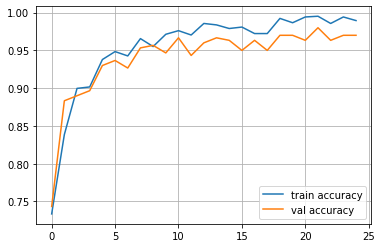

In [18]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
clear_output()
print("Epoch",epoch)
print("Train accuracy:", train_log[-1])
print("Val accuracy:", val_log[-1])
plt.plot(train_log, label='train accuracy')
plt.plot(val_log, label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
    

As we can see we have successfully trained a MLP which was purely written in numpy with high validation accuracy!

## Classification report.

Look at the precision column and you will see the percentage of right prediction to each number. The closer to 1 the best

In [19]:
def evaluate(testData, testLabel):
    predictions = [predict(network,item) for item in testData]
    print(classification_report(testLabel, predictions))

evaluate(X_train, y_train)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       106
           1       0.95      1.00      0.98       104
           2       1.00      1.00      1.00        93
           3       1.00      0.99      0.99       100
           4       0.99      0.99      0.99       105
           5       0.97      1.00      0.99       109
           6       1.00      0.99      1.00       107
           7       1.00      1.00      1.00       109
           8       0.98      0.96      0.97       105
           9       1.00      0.97      0.99       109

    accuracy                           0.99      1047
   macro avg       0.99      0.99      0.99      1047
weighted avg       0.99      0.99      0.99      1047



## Random test



In [20]:
print("[INFO] Test network with ", y_train[0])
predictions = predict(network, X_train[0])
print("Result = ", predictions)

[INFO] Test network with  4
Result =  4
